In [36]:
#Importing Modules
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision import transforms

import torchmetrics
from torchmetrics import Accuracy
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

import os
import numpy as np
import csv
import matplotlib.pyplot as plt
from PIL import Image

from timeit import default_timer as timer
from tqdm.auto import tqdm
from random import shuffle, seed
from pathlib import Path

#Device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

#Printing Versions
print(f"Pytorch Version : {torch.__version__}")
print(f"Torchvision Version : {torchvision.__version__}")
print(f"Torchmetrics Version : {torchmetrics.__version__}")
print(f"Device : {device}")

Pytorch Version : 2.6.0+cu124
Torchvision Version : 0.21.0+cu124
Torchmetrics Version : 1.7.1
Device : cuda


In [2]:
#Transform Image into Tensors
train_transform = transforms.Compose([
    transforms.Resize([224, 224]),
    transforms.ToTensor(),
    transforms.Normalize(
        mean = [0.5502, 0.4461, 0.3452],
        std = [0.2675, 0.2706, 0.2743],
    )

])

test_transform = transforms.Compose([
    transforms.Resize([224, 224]),
    transforms.ToTensor(),
    transforms.Normalize(
        mean = [0.5502, 0.4461, 0.3452],
        std = [0.2675, 0.2706, 0.2743],
    )
])

In [3]:
#Food101 Dataset
class Food101(Dataset):
    def __init__(self, split = 'train', transform = None):
        
        self.path = Path('/kaggle/input/food41/images')
        self.transform = transform
        self.split = split
        self.classes = [food_class.name for food_class in sorted(self.path.iterdir())]
        self.classes_to_idx = {food_class : index for (index, food_class) in enumerate(self.classes)}
        self.data = []
        
        for food_class in self.classes:
            food_class_index = self.classes_to_idx[food_class]
            food_class_dir = self.path / food_class
            
            foods = sorted(list(food_class_dir.glob('*.jpg')))
            class_length = int(0.8 * len(foods)) if self.split == 'train' else int(0.2 * len(foods))
            split_index = int(0.8 * len(foods))

            if self.split == 'train':
                selected_foods = foods[:split_index]
            else:
                selected_foods = foods[split_index:]

            for food in selected_foods:
                self.data.append((food, food_class_index))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image, label = self.data[idx]
        loaded_image = Image.open(image).convert("RGB")
        if (self.transform):
            transformed_image = self.transform(loaded_image)
            return transformed_image, label
        else:
            return image, label

food101_train = Food101(split = 'train', transform = train_transform)
food101_test = Food101(split = 'test', transform = test_transform)

In [4]:
print(len(food101_train))
print(len(food101_test))
print(len(food101_train.classes)) 

80800
20200
101


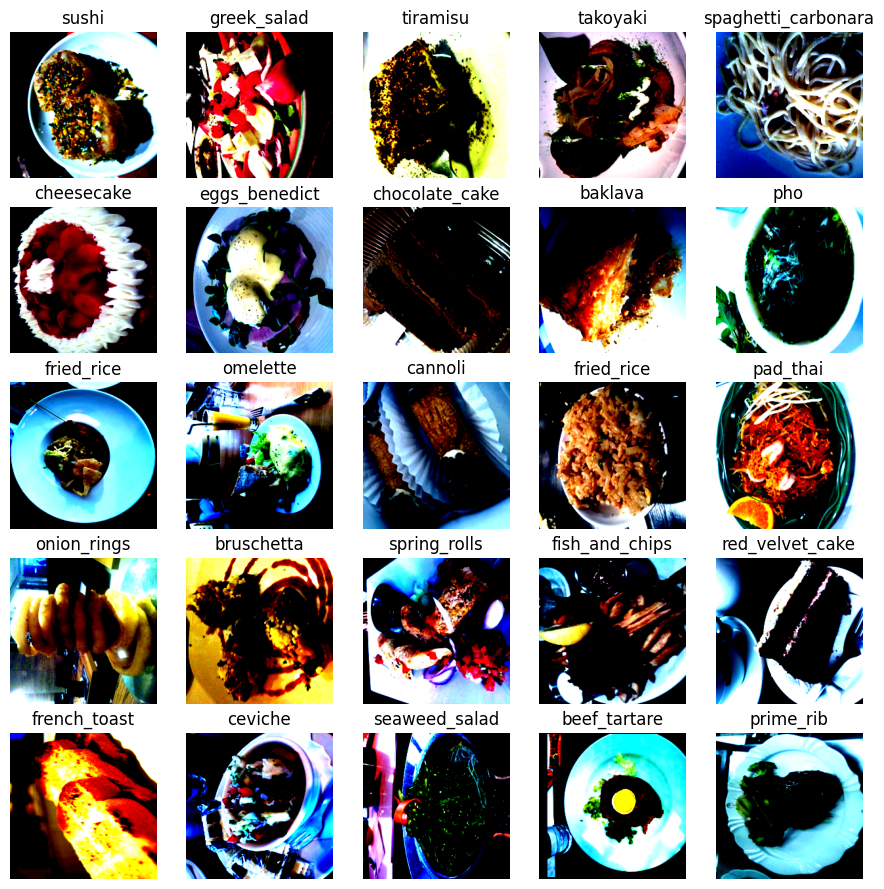

In [5]:
#Visualise
def visualise(dataset : Dataset, 
              index : int):

    image, label = dataset[index]   
    permuted_image = image.permute(2, 1, 0)
    
    plt.title(dataset.classes[label])
    plt.imshow(permuted_image)
    plt.axis(False)

def grid_display(dataset : Dataset, 
                 rows : int = 5, 
                 columns : int = 5):
    #Visualising Grid
    fig = plt.figure(figsize = (11, 11))
    
    for i in range(1, rows * columns + 1):
        fig.add_subplot(rows, columns, i)
        random_index = torch.randint(0, len(dataset), size = [1]).item()
        visualise(dataset, random_index)

grid_display(dataset = food101_train)

In [6]:
#Hyperparamaters
batch_size = 32
learning_rate = 0.01
random_seed = 18

In [7]:
#DataLoaders

torch.manual_seed(random_seed)

train_dataloader = DataLoader(
    dataset = food101_train,
    batch_size = batch_size,
    shuffle = True,
    num_workers = os.cpu_count()
)

test_dataloader = DataLoader(
    dataset = food101_test,
    batch_size = batch_size,
    shuffle = False,
    num_workers = os.cpu_count()
)

# Normalisation:
mean = []
std = []
for images, label in train_dataloader:
    batch_mean = images.mean(dim = [0, 2, 3])
    batch_std = images.std(dim = [0, 2, 3])
    mean.append(batch_mean)
    std.append(batch_std)

mean = torch.stack(mean).mean(dim = 0)
std = torch.stack(std).mean(dim = 0)
mean, std

(tensor([0.5502, 0.4461, 0.3452]), tensor([0.2675, 0.2706, 0.2743]))

In [8]:
#Save Model Function
def save_model(folder : str,
             file_name : str,
             model : torch.nn.Module):
    modelPath = Path(folder)
    modelPath.mkdir(parents = True, exist_ok = True)
    
    modelName = file_name
    modelSavePath = modelPath / modelName
    
    print(f"Saving Model to : {modelSavePath}")
    torch.save(model.state_dict(), modelSavePath)

#Load Model Function
def load_model(folder : str,
             file_name : str,
             model : torch.nn.Module):
    modelPath = Path(folder)
    
    modelName = file_name
    modelSavePath = modelPath / modelName
    
    model.load_state_dict(torch.load(modelSavePath, weights_only = True))

In [9]:
# Basic Block
class BasicBlock(nn.Module):
    def __init__(self, in_channels : int, out_channels : int, downsampling = False):
        super().__init__()
        
        self.conv_first = nn.Conv2d(
            in_channels = in_channels,
            out_channels = out_channels,
            kernel_size = (3, 3),
            stride = 2 if downsampling else 1,
            padding = 1,
            bias = False
        )
        self.conv_second = nn.Conv2d(
            in_channels = out_channels,
            out_channels = out_channels,
            kernel_size = (3, 3),
            stride = 1,
            padding = 1,
            bias = False
        )
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace = True)
        self.downsampling = nn.Conv2d(
                in_channels = in_channels,
                out_channels = out_channels,
                kernel_size = (1, 1),
                stride = 2,
                padding = 0,
                bias = False
            ) if downsampling else None

    def forward(self, X):
        Y = self.conv_first(X)
        Y = self.bn1(Y)
        Y = self.relu(Y)
        Z = self.conv_second(Y)
        Z = self.bn2(Z)

        if(self.downsampling):
            X = self.downsampling(X)

        Z += X
        Z = self.relu(Z)
        return Z

In [10]:
# ResNet 34 Model
class ResNet34(nn.Module):
    def __init__(self, num_classes : int, in_channels : int = 3):
        super().__init__()

        # Stem Block
        self.conv1_x = nn.Sequential(
            nn.Conv2d(
                in_channels = in_channels,
                out_channels = 64,
                kernel_size = (7, 7),
                stride = 2,
                padding = 3
            ),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(
                kernel_size = (3, 3),
                stride = 2,
                padding = 1
            )
        )

        out_channels = 64
        self.conv2_x, out_channels = self.create_layer(
            in_channels = out_channels,
            out_channels = 64,
            num_blocks = 3,
            stride = 1
        )
        
        self.conv3_x, out_channels = self.create_layer(
            in_channels = out_channels,
            out_channels = 128,
            num_blocks = 4,
            stride = 2
        )
        
        self.conv4_x, out_channels = self.create_layer(
            in_channels = out_channels,
            out_channels = 256,
            num_blocks = 6,
            stride = 2
        )
        
        self.conv5_x, out_channels = self.create_layer(
            in_channels = out_channels,
            out_channels = 512,
            num_blocks = 3,
            stride = 2
        )

        self.fc = nn.Linear(
            in_features = out_channels,
            out_features = num_classes
        )
        
    def create_layer(self, in_channels : int, out_channels : int, num_blocks : int, stride : int):
        layer_blocks = []
        
        # Block 1
        block1 = BasicBlock(
             in_channels = in_channels,
             out_channels = out_channels,
             downsampling = (stride == 2)
            )
        layer_blocks.append(block1)
        
        for block_index in range(num_blocks - 1):
            block = BasicBlock(
                in_channels = out_channels,
                out_channels = out_channels,
                downsampling = False
            )
            layer_blocks.append(block)

        return nn.Sequential(*layer_blocks), out_channels

    def forward(self, X):
        X = self.conv1_x(X)
        X = self.conv2_x(X)
        X = self.conv3_x(X)
        X = self.conv4_x(X)
        Y = self.conv5_x(X)

        Y = nn.AdaptiveAvgPool2d(
            output_size = (1, 1)
        )(Y)
        
        Y = torch.flatten(Y, 1)
        Z = self.fc(Y)

        return Z

Food101Model = ResNet34(num_classes = len(food101_train.classes))
Food101Model

ResNet34(
  (conv1_x): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=(3, 3), stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (conv2_x): Sequential(
    (0): BasicBlock(
      (conv_first): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (conv_second): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
    (1): BasicBlock(
      (conv_first): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (conv_second): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (

In [11]:
#Optimiser and Loss Function
loss = nn.CrossEntropyLoss()

optimiser = torch.optim.SGD(
    Food101Model.parameters(),
    lr = learning_rate,
    momentum = 0.9,
    weight_decay = 1e-4
)

scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer = optimiser,
    gamma = 0.1,
    step_size = 8
)

accuracy = Accuracy(task = "multiclass", num_classes = len(food101_train.classes)).to(device)

#Timer Function
def display_time(start_time,
              end_time,
              device : torch.device = device):
    time = end_time - start_time
    print(f"Total Time : {time} on device {device}.")

In [12]:
#Training Loop
def train_step(
    model : torch.nn.Module,
    dataloader : torch.utils.data.DataLoader,
    loss_function : torch.nn,
    accuracy_function,
    optimiser : torch.optim.Optimizer,
    device : torch.device = device
):
    model.train()
    
    train_loss, train_accuracy = 0, 0
    model.to(device)

    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        yLogits = model(X)
        yPreds = torch.argmax(torch.softmax(yLogits, dim = 1), dim = 1)

        loss = loss_function(yLogits, y)
        train_loss += loss

        optimiser.zero_grad()
        loss.backward()
        optimiser.step()

        accuracy = accuracy_function(yPreds, y)
        train_accuracy += accuracy

        if (batch % 400) == 0:
            print(f'Looked at Batch No: {batch}. {batch * len(X)} / {len(train_dataloader.dataset)} samples')

    train_loss /= len(dataloader)
    train_accuracy /= len(dataloader)

    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_accuracy * 100:.2f}%")

    return train_loss

def test_step(
    model : torch.nn.Module,
    dataloader : torch.utils.data.DataLoader,
    loss_function : torch.nn,
    accuracy_function,
    device : torch.device = device
):
    model.eval()

    test_loss, test_accuracy = 0, 0
    model.to(device)

    with torch.inference_mode():
        for (X, y) in dataloader:
            X, y = X.to(device), y.to(device)
    
            yLogits = model(X)
            yPreds = torch.argmax(torch.softmax(yLogits, dim = 1), dim = 1)
    
            loss = loss_function(yLogits, y)
            test_loss += loss
    
            accuracy = accuracy_function(yPreds, y)
            test_accuracy += accuracy

        test_loss /= len(dataloader)
        test_accuracy /= len(dataloader)
    
        print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_accuracy * 100:.2f}%")

    return test_loss

In [13]:
#Training Model
train_loss_list = []
test_loss_list = []

#Training
def training(
    model : torch.nn.Module,
    epochs : int,
    train_dataloader : torch.utils.data.DataLoader,
    test_dataloader : torch.utils.data.DataLoader,
    loss_function : torch.nn,
    accuracy_function,
    optimiser : torch.optim.Optimizer,
    device : torch.device = device
):  
    for epoch in tqdm(range(epochs)):
        print(f'Epochs : {epoch + 1}\n---------')
        train_loss = train_step(
            model = model,
            dataloader = train_dataloader,
            loss_function = loss_function,
            accuracy_function = accuracy_function,
            optimiser = optimiser,
            device = device
            )
    
        test_loss = test_step(
            model = model,
            dataloader = test_dataloader,
            loss_function = loss_function,
            accuracy_function = accuracy_function,
            device = device
        )   

        train_loss_list.append(train_loss.to('cpu').item())
        test_loss_list.append(test_loss.to('cpu').item())
        
        scheduler.step()

In [14]:
#Model Before Training
test_step(
    model = Food101Model,
    dataloader = test_dataloader,
    loss_function = loss,
    accuracy_function = accuracy,
    device = device
) 


print("---------------------------------------------------------------------------------------")

start_time = timer()

training(
    model = Food101Model,
    epochs = 10,
    train_dataloader = train_dataloader,
    test_dataloader = test_dataloader,
    loss_function = loss,
    accuracy_function = accuracy,
    optimiser = optimiser,
    device = device
)

end_time = timer()
display_time(
    start_time  = start_time,
    end_time = end_time,
    device = device
)

Test loss: 4.61594 | Test accuracy: 0.89%
---------------------------------------------------------------------------------------


  0%|          | 0/10 [00:00<?, ?it/s]

Epochs : 1
---------
Looked at Batch No: 0. 0 / 80800 samples
Looked at Batch No: 400. 12800 / 80800 samples
Looked at Batch No: 800. 25600 / 80800 samples
Looked at Batch No: 1200. 38400 / 80800 samples
Looked at Batch No: 1600. 51200 / 80800 samples
Looked at Batch No: 2000. 64000 / 80800 samples
Looked at Batch No: 2400. 76800 / 80800 samples
Train loss: 4.14998 | Train accuracy: 7.20%
Test loss: 3.78648 | Test accuracy: 12.54%
Epochs : 2
---------
Looked at Batch No: 0. 0 / 80800 samples
Looked at Batch No: 400. 12800 / 80800 samples
Looked at Batch No: 800. 25600 / 80800 samples
Looked at Batch No: 1200. 38400 / 80800 samples
Looked at Batch No: 1600. 51200 / 80800 samples
Looked at Batch No: 2000. 64000 / 80800 samples
Looked at Batch No: 2400. 76800 / 80800 samples
Train loss: 3.51207 | Train accuracy: 17.27%
Test loss: 3.24407 | Test accuracy: 22.79%
Epochs : 3
---------
Looked at Batch No: 0. 0 / 80800 samples
Looked at Batch No: 400. 12800 / 80800 samples
Looked at Batch No: 

In [15]:
#Model Evaluation
test_step(
    model = Food101Model,
    dataloader = test_dataloader,
    loss_function = loss,
    accuracy_function = accuracy,
    device = device
) 

Test loss: 1.84114 | Test accuracy: 57.28%


tensor(1.8411, device='cuda:0')

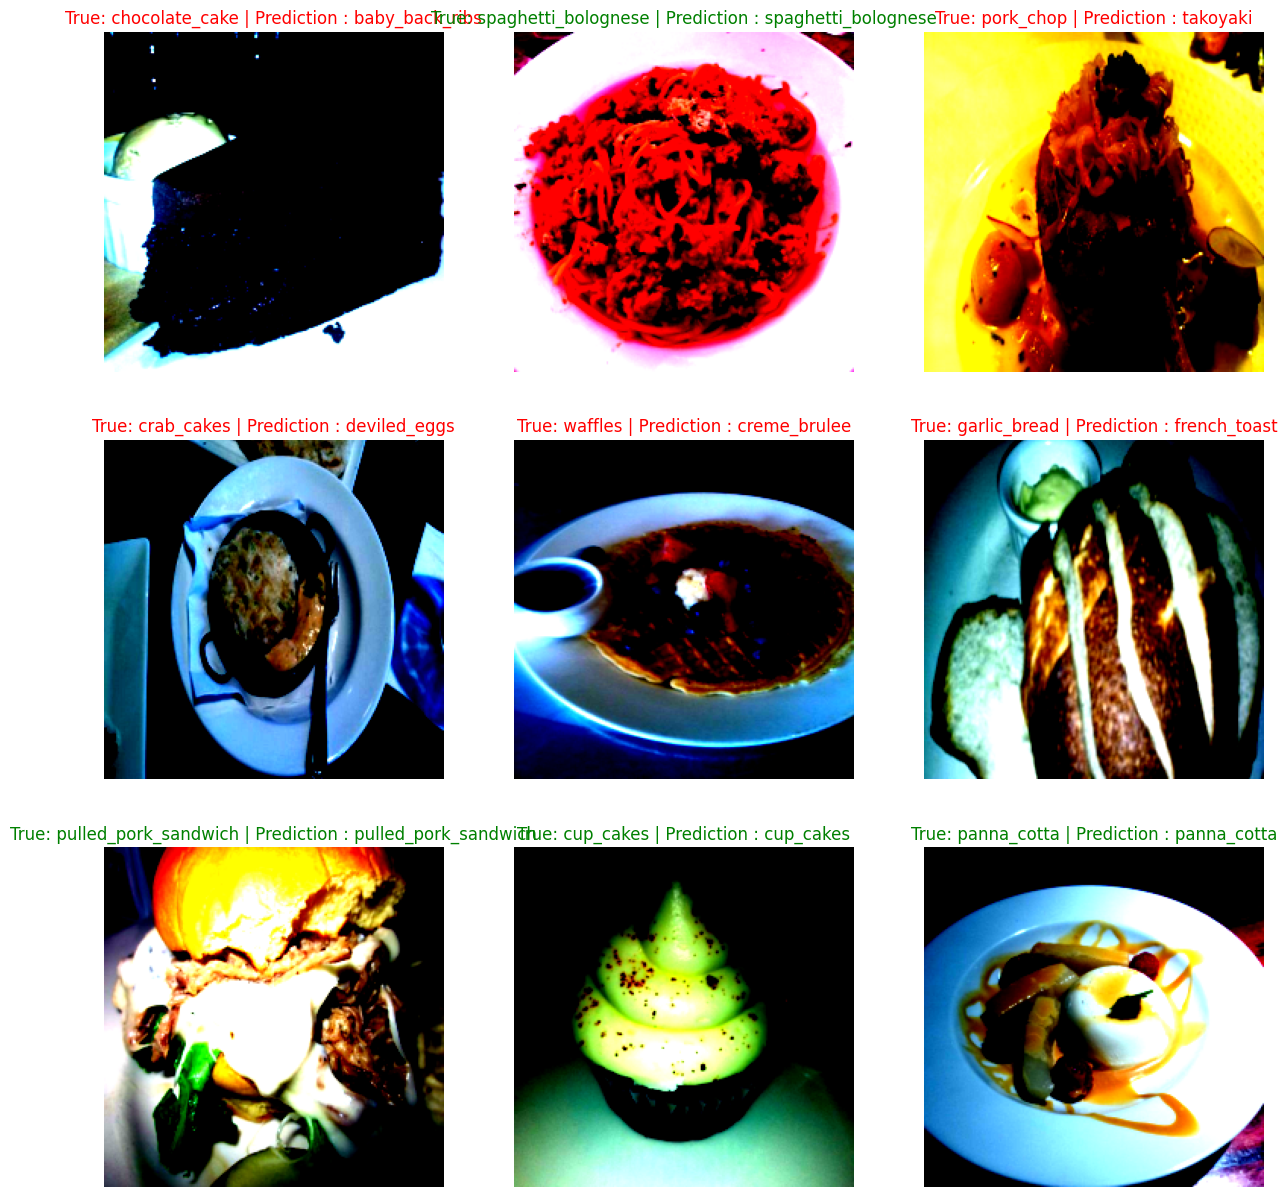

In [26]:
#Visualising Grid
fig = plt.figure(figsize = (15, 15))
rows, cols = 3, 3



for i in range(1, rows * cols + 1):
    fig.add_subplot(rows, cols, i)
    idx = torch.randint(0, len(food101_test), size = [1]).item()
    img, label = food101_test[idx]

    img = img.unsqueeze(0).to(device)
    logits = Food101Model(img)
    preds = torch.argmax(torch.softmax(logits, dim = 1), dim = 1)

    label = food101_test.classes[label]
    preds = food101_test.classes[preds]

    if label == preds:
        color = 'green'
    else:
        color = 'red'

    img = img.squeeze().permute(1, 2, 0).to('cpu')
    
    plt.title(f"True: {label} | Prediction : {preds}", color = color)
    plt.imshow(img)
    plt.axis(False)

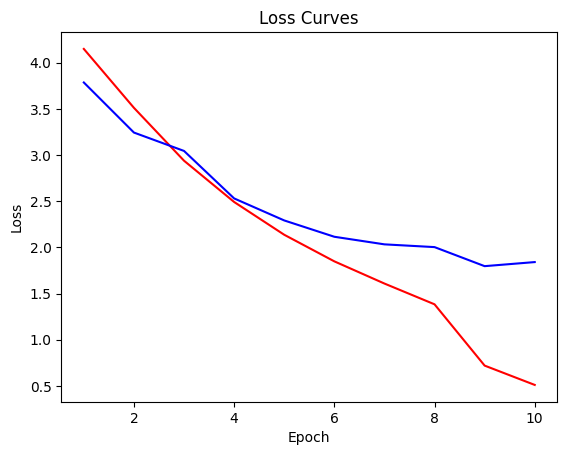

In [27]:
train_loss = train_loss_list
test_loss = test_loss_list
epochs = list(range(1, len(train_loss_list) + 1))

plt.plot(epochs, train_loss, color = "red")
plt.plot(epochs, test_loss, color = "blue")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curves")
plt.show()

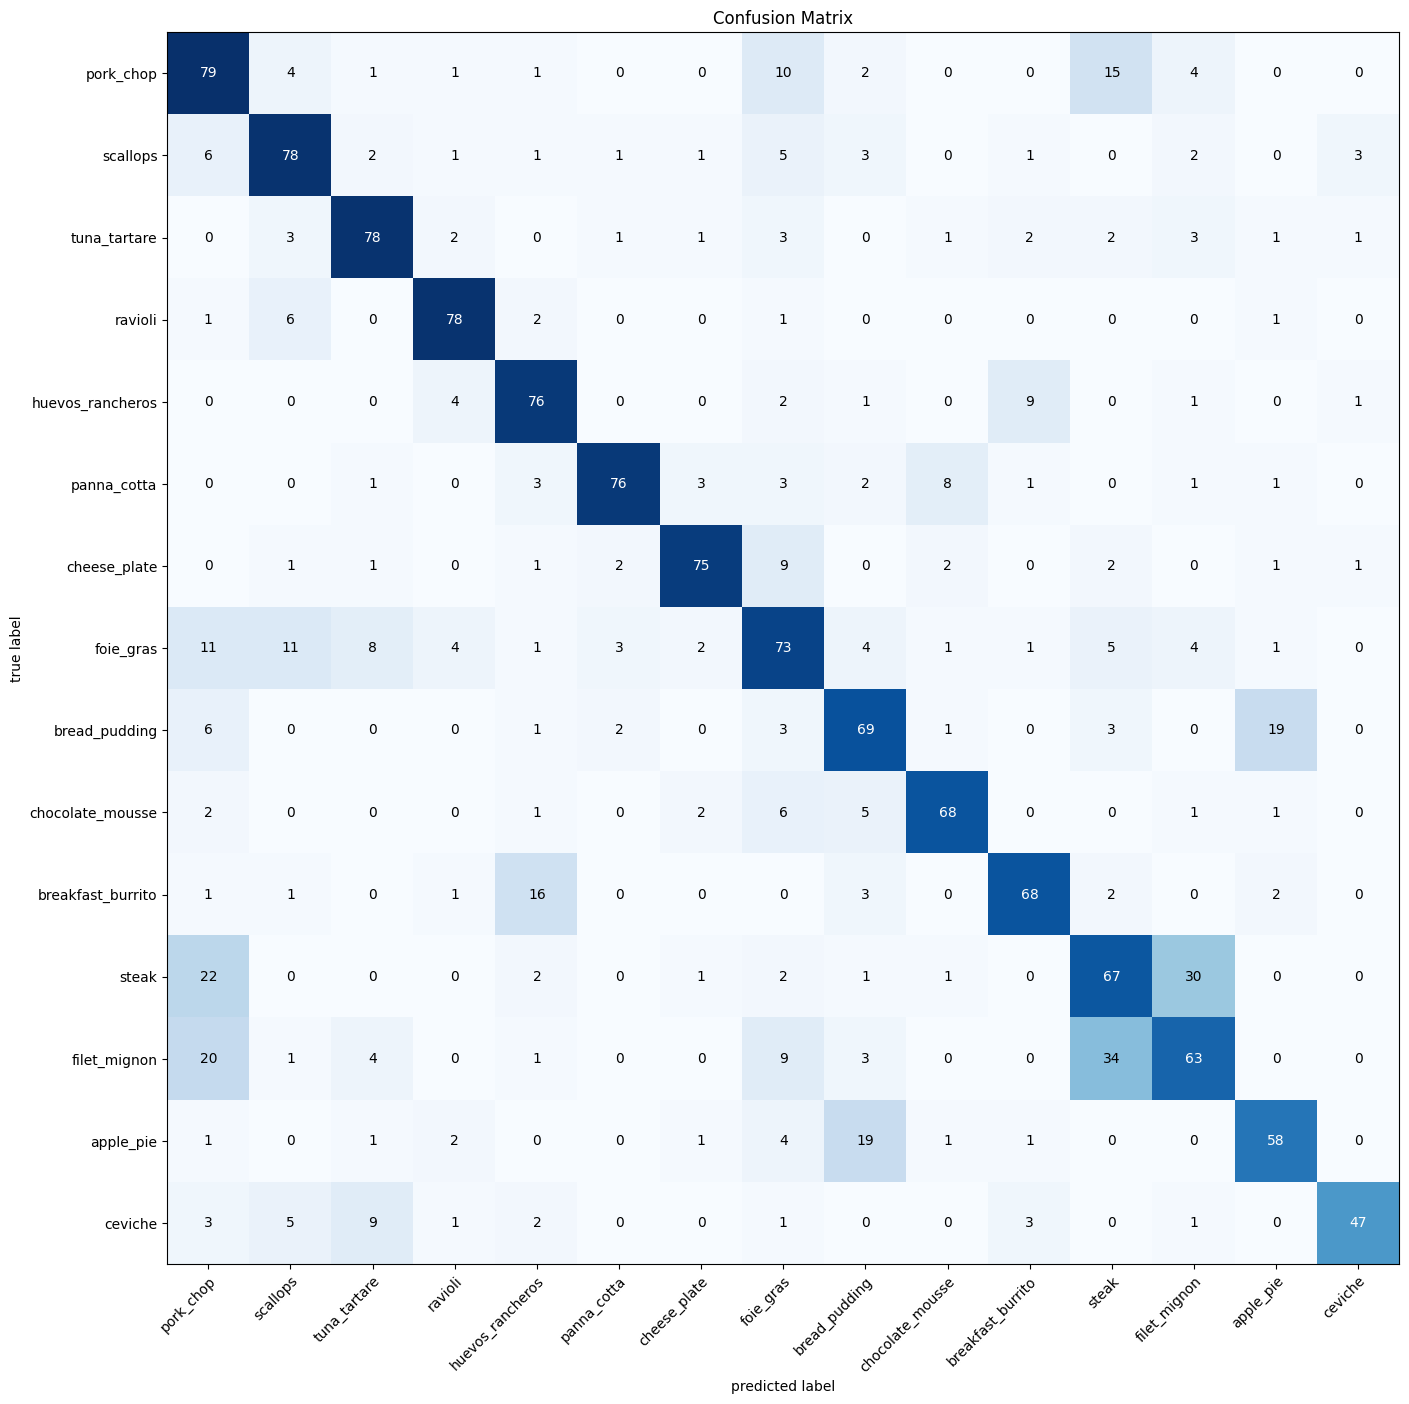

In [38]:
# Confusion Matrix
def plot_cf(top_n_classes : int = 15):
    confmat = ConfusionMatrix(num_classes=len(food101_train.classes), task="multiclass").to(device)
    Food101Model.eval()
    Food101Model.to(device)
    
    with open('submissions.csv', 'w', newline='') as file:
        fileWriter = csv.writer(file)
        fileWriter.writerow(['id', 'prediction', 'true'])
    
        id = 0
        with torch.inference_mode():
            for X, y in test_dataloader:
                X, y = X.to(device), y.to(device)
    
                yLogits = Food101Model(X)
                yPreds = torch.argmax(torch.softmax(yLogits, dim=1), dim=1)
    
                confmat.update(yPreds, y)
    
                for pred, true in zip(yPreds, y):
                    fileWriter.writerow([id, int(pred.item()), int(true.item())])
                    id += 1
    
    # Plot ConfMat
    cf = confmat.compute().cpu().numpy()
    
    confusion_sums = cf.sum(axis = 1) - np.diag(cf)
    top_classes_idx = np.argsort(confusion_sums)[-top_n_classes:]

    cf_top = cf[np.ix_(top_classes_idx, top_classes_idx)]
    top_class_names = [food101_train.classes[i] for i in top_classes_idx]
    
    fig, ax = plot_confusion_matrix(
        conf_mat = cf_top,
        figsize = (16, 16),
        class_names = top_class_names
    )
    plt.title("Confusion Matrix")
    plt.show()

plot_cf()

In [39]:
save_model(
    folder = "/kaggle/working/",
    file_name = "food101_v1_resnet34.pth",
    model = Food101Model
)

Saving Model to : /kaggle/working/food101_v1_resnet34.pth
